## Training (Text_Image_CA)

In [ ]:
pip install torchnet

In [2]:
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, confusion_matrix

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/FML Project') 

## Set Device

In [4]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Features and Labels

In [5]:
label_path = sys.path[-1]+"/Data/labels.npy"
text_path = sys.path[-1]+"/Data/text_features_256.pt"
image_path = sys.path[-1]+"/Data/image_features.pt"

In [6]:
labels = np.load(label_path)
print('Labels loaded!')

Labels loaded!


In [7]:
image_features = torch.load(image_path)
print('Image features loaded!')

Image features loaded!


In [8]:
text_features = torch.load(text_path)
print('Text features loaded!')

Text features loaded!


## Split Data

In [9]:
df = pd.read_csv(sys.path[-1]+"/Data/df_final.csv")
train_ids = list(df[df['target_date'] < '2015-08-01'].index)
valid_ids = list(df[df['target_date'].between('2015-08-01','2015-10-01')].index)
test_ids = list(df[df['target_date'] > '2015-10-01'].index)
print(len(train_ids), len(valid_ids), len(test_ids))

14040 1910 2593


In [10]:
dataset = TensorDataset([text_features.float(), image_features.float(), torch.tensor(labels).float()])

train_set = TensorDataset([torch.utils.data.Subset(dataset, train_ids)])
valid_set = TensorDataset([torch.utils.data.Subset(dataset, valid_ids)])
test_set = TensorDataset([torch.utils.data.Subset(dataset, test_ids)])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print('Datasets ready!')

Datasets ready!


## Evaluation Metrics

In [11]:
def compute_accuracy(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return accuracy_score(np.array(y_true), np.array(y_pred))

def compute_f1(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return f1_score(np.array(y_true), np.array(y_pred))

def compute_MCC(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return matthews_corrcoef(np.array(y_true), np.array(y_pred))

def evaluate_metrics(preds, labels):
    labels = [int(item) for item in labels]
    preds = [0 if item < 0.5 else 1 for item in preds]
    accuracy = compute_accuracy(labels, preds)
    f1 = compute_f1(labels, preds)
    mcc = compute_MCC(labels, preds)
    cm = confusion_matrix(labels, preds)
    return accuracy, f1, mcc, cm

## Training

In [12]:
def save_model(model, name):
    torch.save(model.state_dict(), name)

def load_model(model, name):
    weights = torch.load(name)
    model.load_state_dict(weights)
    return model

In [13]:
def train_model(model, params, train_loader, valid_loader, test_loader, report_loss=True):

    device = params['device']
    n_epochs = params['n_epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    scheduler = params['scheduler']

    stop = 0
    best_valid_mcc = -1

    valid_metrics = {}
    test_metrics = {}
    train_loss, valid_loss, test_loss = [], [], []
    valid_a, valid_f1, valid_mcc, valid_cm = [], [], [], []
    test_a, test_f1, test_mcc, test_cm = [], [], [], []

    f = nn.Sigmoid()

    for epoch in range(n_epochs):

        train_loss_i, batch, total = 0.0, 0, 0
        model.train()
        for data in tqdm(train_loader):
            if params['model_type'] == 'unimodal':
                x, labels = data[0][0].to(device), data[0][1].to(device)
                preds = model(x)
            elif params['model_type'] == 'bimodal':
                x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                preds = model(x_txt, x_img)
            preds = f(preds).squeeze()
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_i += loss.item()
            batch += 1
            total += labels.shape[0]
            if report_loss and batch%200==0:
                print("Batch: {}, Training Loss: {:.4f}".format(batch, train_loss_i/total))
        train_loss_i = train_loss_i / len(train_loader.dataset)

        valid_loss_i = 0.0
        valid_preds, valid_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(valid_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                valid_loss_i += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
        valid_loss_i = valid_loss_i / len(valid_loader.dataset)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)

        valid_a_i, valid_f1_i, valid_mcc_i, valid_cm_i = evaluate_metrics(valid_preds, valid_labels)

        test_loss_i = 0.0
        test_preds, test_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                test_loss_i += loss.item()
                test_preds.append(preds)
                test_labels.append(labels)
        test_loss_i = test_loss_i / len(test_loader.dataset)
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)

        test_a_i, test_f1_i, test_mcc_i, test_cm_i = evaluate_metrics(test_preds, test_labels)

        scheduler.step(valid_loss_i)  # decay learning rate by validation loss

        if valid_mcc_i > best_valid_mcc:
            save_model(model, sys.path[-1]+'/Models/'+params['model_name']+'.pt')
            print("Saved model at epoch {} with validation MCC score of {:.4f}%".format(epoch+1, valid_mcc_i))
            best_valid_mcc = valid_mcc_i

        if report_loss:
            print("\n")
            print("-" * 50)
            print("Epoch ", epoch+1)
            print("Training Loss: {:.4f}, Validation Loss: {:.4f}".format(train_loss_i, valid_loss_i))
            print('Validation Results: ')
            print("Accuracy: {:.4f}".format(valid_a_i))
            print("F1 Score: {:.4f}".format(valid_f1_i))
            print("MCC Score: {:.4f}".format(valid_mcc_i))
            print('Test Results: ')
            print("Accuracy: {:.4f}".format(test_a_i))
            print("F1 Score: {:.4f}".format(test_f1_i))
            print("MCC Score: {:.4f}".format(test_mcc_i))
            print("-" * 50)
            print("\n")
        
        train_loss.append(train_loss_i)
        valid_loss.append(valid_loss_i)
        test_loss.append(test_loss_i)

        valid_a.append(valid_a_i)
        valid_f1.append(valid_f1_i)
        valid_mcc.append(valid_mcc_i)
        valid_cm.append(valid_cm_i)

        test_a.append(test_a_i)
        test_f1.append(test_f1_i)
        test_mcc.append(test_mcc_i)
        test_cm.append(test_cm_i)


        if len(valid_loss) > 0:  
            if valid_loss_i <= valid_loss[-1]:
                stop = 0
            else:
                stop += 1
                if stop >= int(params['n_stop']):   # stop training when no improvement observed in consecutive epoches
                    print("Early stopped. No improvement in validation loss for params['n_stop'] consecutive epoches.")
                    break

    valid_metrics['acc'] = valid_a
    valid_metrics['f1'] = valid_f1
    valid_metrics['mcc'] = valid_mcc
    valid_metrics['cm'] = valid_cm

    test_metrics['acc'] = test_a
    test_metrics['f1'] = test_f1
    test_metrics['mcc'] = test_mcc
    test_metrics['cm'] = test_cm

    return train_loss, valid_loss, test_loss, valid_metrics, test_metrics

## Models

In [ ]:
class Text_Image_CA(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_CA, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        # classification
        y = self.classifier(x_vt.squeeze())
        return y

In [ ]:
class Text_Image_CA2(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_CA2, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout_fused = nn.Dropout(p=params['fused_dropout'])
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        self.mha_tv = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['tv_H'],
                                            dropout=params['tv_dropout'],
                                            batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.concat_linear = nn.Linear(in_features=int(2*params['hidden_size']),
                                       out_features=int(0.5*params['hidden_size']))
        self.classifier = nn.Linear(in_features=int(0.5*params['hidden_size']),
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        x_tv, _ = self.mha_vt(x_txt, x_img.unsqueeze(dim=1), x_img.unsqueeze(dim=1))
        # temporal average as global representation
        x_tv = torch.mean(x_tv, dim=1)
        # fusion with concatenation
        x_fused = torch.cat((x_vt.squeeze(), x_tv.squeeze()), dim=1)
        x_fused = self.dropout_fused(self.concat_linear(x_fused))
        # classification
        y = self.classifier(x_fused)
        return y

In [ ]:
class Text_Image_CA3(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_CA3, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout_fused = nn.Dropout(p=params['fused_dropout'])
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        self.mha_tv = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['tv_H'],
                                            dropout=params['tv_dropout'],
                                            batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.concat_linear = nn.Linear(in_features=int(2*params['hidden_size']),
                                       out_features=int(0.5*params['hidden_size']))
        self.classifier = nn.Linear(in_features=int(0.5*params['hidden_size']),
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        x_tv, _ = self.mha_vt(x_txt, x_img.unsqueeze(dim=1), x_img.unsqueeze(dim=1))
        # temporal average as global representation
        x_tv = torch.mean(x_tv, dim=1)
        # fusion with statistical pooling
        x_fused = torch.stack((x_vt.squeeze(), x_tv.squeeze()), dim=1)
        x_std, x_mean = torch.std_mean(x_fused, dim=1)
        x_fused = torch.cat((x_std, x_mean), dim=1)
        x_fused = self.dropout_fused(self.concat_linear(x_fused))
        # classification
        y = self.classifier(x_fused)
        return y

In [ ]:
class Text_Image_CA4(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_CA4, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        # multi-heads cross-attention
        self.mha_fuse = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                              num_heads=params['vt_H'],
                                              dropout=params['vt_dropout'],
                                              batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # fusion with Hadamard product
        x_fused = torch.mul(x_txt, x_img.unsqueeze(dim=1))
        # self-attention
        x_fused, _ = self.mha_fuse(x_fused, x_fused, x_fused)
        # temporal average as global representation
        x_fused = torch.mean(x_fused, dim=1)
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

In [ ]:
class Text_Image_CA5(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_CA5, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        # multi-heads cross-attention
        self.mha_txt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                             num_heads=params['txt_H'],
                                             dropout=params['txt_dropout'],
                                             batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # self-attention
        x_txt, _ = self.mha_txt(x_txt, x_txt, x_txt)
        # temporal average as global representation
        x_txt = torch.mean(x_txt, dim=1)
        # fusion with Hadamard product
        x_fused = torch.mul(x_txt, x_img)
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

In [ ]:
class Text_Image_CA6(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_CA6, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout_fused = nn.Dropout(p=params['fused_dropout'])
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        self.mha_tv = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['tv_H'],
                                            dropout=params['tv_dropout'],
                                            batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        x_tv, _ = self.mha_vt(x_txt, x_img.unsqueeze(dim=1), x_img.unsqueeze(dim=1))
        # temporal average as global representation
        x_tv = torch.mean(x_tv, dim=1)
        # fusion with Hadamard product
        x_fused = torch.mul(x_vt.squeeze(), x_tv.squeeze())
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

In [14]:
class Text_Image_SA(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and self-attention.
    """
    def __init__(self, params):
        super(Text_Image_SA, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout_fused = nn.Dropout(p=params['fused_dropout'])
        # multi-heads cross-attention
        self.mha_txt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                             num_heads=params['txt_H'],
                                             dropout=params['txt_dropout'],
                                             batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.concat_linear = nn.Linear(in_features=int(2*params['hidden_size']),
                                       out_features=int(0.5*params['hidden_size']))
        self.classifier = nn.Linear(in_features=int(0.5*params['hidden_size']),
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # self-attention
        x_txt, _ = self.mha_txt(x_txt, x_txt, x_txt)
        # temporal average as global representation
        x_txt = torch.mean(x_txt, dim=1)
        # fusion with concatenation
        x_fused = torch.cat((x_txt, x_img), dim=1)
        x_fused = self.dropout_fused(self.concat_linear(x_fused))
        # classification
        y = self.classifier(x_fused)
        return y

In [15]:
class Text_Image_SA2(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and self-attention.
    """
    def __init__(self, params):
        super(Text_Image_SA2, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout_fused = nn.Dropout(p=params['fused_dropout'])
        # multi-heads cross-attention
        self.mha_txt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                             num_heads=params['txt_H'],
                                             dropout=params['txt_dropout'],
                                             batch_first=True)
        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.concat_linear = nn.Linear(in_features=int(2*params['hidden_size']),
                                       out_features=int(0.5*params['hidden_size']))
        self.classifier = nn.Linear(in_features=int(0.5*params['hidden_size']),
                                    out_features=1)

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # self-attention
        x_txt, _ = self.mha_txt(x_txt, x_txt, x_txt)
        # temporal average as global representation
        x_txt = torch.mean(x_txt, dim=1)
        # fusion with statistical pooling
        x_fused = torch.stack((x_txt, x_img), dim=1)
        x_std, x_mean = torch.std_mean(x_fused, dim=1)
        x_fused = torch.cat((x_std, x_mean), dim=1)
        x_fused = self.dropout_fused(self.concat_linear(x_fused))
        # classification
        y = self.classifier(x_fused)
        return y

## Bimodal

In [16]:
model_params = {'txt_embed_size': 768,
                'img_embed_size': 2048,
                'hidden_size': 512,
                'txt_H': 4,
                'vt_H': 4,
                'tv_H': 4,
                'txt_dropout': 0.01,
                'img_dropout': 0.01,
                'vt_dropout': 0.01,
                'tv_dropout': 0.01,
                'fused_dropout': 0.01,
                'transformer_dropout': 0.01}  

best_acc, best_f1, best_mcc, best_cm = [], [], [], []

for i in range(5):

    model = Text_Image_SA2(model_params)
    model.to(device)
    criterion = nn.BCELoss()    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    train_params = {'n_epochs': 30,
                    'criterion': criterion,
                    'optimizer': optimizer,
                    'scheduler': scheduler,
                    'n_stop': 8,
                    'model_name': 'Text_Image_SA2',
                    'model_type': 'bimodal',
                    'device': device}

    train_loss, valid_loss, test_loss, valid_metrics, test_metrics = train_model(model, train_params, train_loader, valid_loader, test_loader)
        
    idx = np.argmax(test_metrics['mcc'])
    best_acc.append(test_metrics['acc'][idx])
    best_f1.append(test_metrics['f1'][idx])
    best_mcc.append(test_metrics['mcc'][idx])
    best_cm.append(test_metrics['cm'][idx])

    with open(sys.path[-1]+f"/Training Results/train_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(train_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_loss, f)
    with open(sys.path[-1]+f"/Training Results/test_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_metrics, f)
    with open(sys.path[-1]+f"/Training Results/test_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_metrics, f)

 47%|████▋     | 205/439 [00:09<00:07, 30.08it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 405/439 [00:16<00:01, 29.90it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 11.87it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 31.88it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 404/439 [00:12<00:01, 31.87it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 12.26it/s]


Saved model at epoch 2 with validation MCC score of 0.0209%


--------------------------------------------------
Epoch  2
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.6246
MCC Score: 0.0209
Test Results: 
Accuracy: 0.5245
F1 Score: 0.6881
MCC Score: -0.0187
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 31.17it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 403/439 [00:12<00:01, 31.42it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 11.88it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6241
MCC Score: -0.0030
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6881
MCC Score: 0.0020
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 31.58it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 404/439 [00:12<00:01, 31.14it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 12.35it/s]


Saved model at epoch 4 with validation MCC score of 0.0440%


--------------------------------------------------
Epoch  4
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5471
F1 Score: 0.2688
MCC Score: 0.0440
Test Results: 
Accuracy: 0.4790
F1 Score: 0.2448
MCC Score: -0.0117
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.87it/s]

Batch: 200, Training Loss: 0.0215


 92%|█████████▏| 403/439 [00:13<00:01, 31.00it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:01<00:00, 12.13it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0215, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4749
F1 Score: 0.5712
MCC Score: -0.0005
Test Results: 
Accuracy: 0.5195
F1 Score: 0.6135
MCC Score: 0.0192
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.71it/s]

Batch: 200, Training Loss: 0.0213


 92%|█████████▏| 405/439 [00:13<00:01, 29.67it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:01<00:00, 11.80it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0213, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4827
F1 Score: 0.5383
MCC Score: -0.0041
Test Results: 
Accuracy: 0.5083
F1 Score: 0.5723
MCC Score: 0.0043
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.98it/s]

Batch: 200, Training Loss: 0.0210


 92%|█████████▏| 404/439 [00:13<00:01, 30.75it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:01<00:00, 12.25it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0209, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.5147
MCC Score: 0.0100
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5181
MCC Score: 0.0273
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 31.24it/s]

Batch: 200, Training Loss: 0.0204


 92%|█████████▏| 404/439 [00:13<00:01, 29.96it/s]

Batch: 400, Training Loss: 0.0203


100%|██████████| 21/21 [00:01<00:00, 11.45it/s]


Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  8
Training Loss: 0.0204, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.4741
MCC Score: 0.0081
Test Results: 
Accuracy: 0.4948
F1 Score: 0.4569
MCC Score: -0.0010
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 31.38it/s]

Batch: 200, Training Loss: 0.0192


 92%|█████████▏| 404/439 [00:13<00:01, 31.09it/s]

Batch: 400, Training Loss: 0.0190


100%|██████████| 21/21 [00:01<00:00, 12.19it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0191, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4963
F1 Score: 0.5357
MCC Score: 0.0175
Test Results: 
Accuracy: 0.5079
F1 Score: 0.5353
MCC Score: 0.0125
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.69it/s]

Batch: 200, Training Loss: 0.0180


 92%|█████████▏| 403/439 [00:13<00:01, 30.60it/s]

Batch: 400, Training Loss: 0.0182


100%|██████████| 21/21 [00:01<00:00, 12.05it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0182, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5065
MCC Score: 0.0127
Test Results: 
Accuracy: 0.5102
F1 Score: 0.5115
MCC Score: 0.0227
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.93it/s]

Batch: 200, Training Loss: 0.0172


 92%|█████████▏| 405/439 [00:13<00:01, 30.32it/s]

Batch: 400, Training Loss: 0.0172


100%|██████████| 21/21 [00:01<00:00, 12.22it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0173, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5166
MCC Score: 0.0236
Test Results: 
Accuracy: 0.5106
F1 Score: 0.5140
MCC Score: 0.0230
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.23it/s]

Batch: 200, Training Loss: 0.0162


 92%|█████████▏| 405/439 [00:13<00:01, 30.33it/s]

Batch: 400, Training Loss: 0.0165


100%|██████████| 21/21 [00:01<00:00, 12.13it/s]


Epoch 00012: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  12
Training Loss: 0.0165, Validation Loss: 0.0067
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5198
MCC Score: 0.0241
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5140
MCC Score: 0.0119
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.92it/s]

Batch: 200, Training Loss: 0.0149


 92%|█████████▏| 404/439 [00:13<00:01, 30.00it/s]

Batch: 400, Training Loss: 0.0151


100%|██████████| 21/21 [00:01<00:00, 12.01it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0151, Validation Loss: 0.0076
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.5650
MCC Score: 0.0315
Test Results: 
Accuracy: 0.5168
F1 Score: 0.5852
MCC Score: 0.0204
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.56it/s]

Batch: 200, Training Loss: 0.0142


 92%|█████████▏| 405/439 [00:13<00:01, 30.09it/s]

Batch: 400, Training Loss: 0.0143


100%|██████████| 21/21 [00:01<00:00, 12.32it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0143, Validation Loss: 0.0071
Validation Results: 
Accuracy: 0.5262
F1 Score: 0.4698
MCC Score: 0.0417
Test Results: 
Accuracy: 0.5121
F1 Score: 0.4578
MCC Score: 0.0380
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.78it/s]

Batch: 200, Training Loss: 0.0135


 92%|█████████▏| 406/439 [00:13<00:01, 30.72it/s]

Batch: 400, Training Loss: 0.0137


100%|██████████| 21/21 [00:01<00:00, 11.13it/s]


Saved model at epoch 15 with validation MCC score of 0.0522%


--------------------------------------------------
Epoch  15
Training Loss: 0.0137, Validation Loss: 0.0078
Validation Results: 
Accuracy: 0.5157
F1 Score: 0.5428
MCC Score: 0.0522
Test Results: 
Accuracy: 0.5195
F1 Score: 0.5416
MCC Score: 0.0367
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.92it/s]

Batch: 200, Training Loss: 0.0129


 92%|█████████▏| 405/439 [00:13<00:01, 29.28it/s]

Batch: 400, Training Loss: 0.0131


100%|██████████| 21/21 [00:01<00:00, 12.12it/s]


Epoch 00016: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  16
Training Loss: 0.0132, Validation Loss: 0.0080
Validation Results: 
Accuracy: 0.5173
F1 Score: 0.5329
MCC Score: 0.0501
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5216
MCC Score: 0.0180
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:08, 29.11it/s]

Batch: 200, Training Loss: 0.0121


 92%|█████████▏| 404/439 [00:13<00:01, 30.57it/s]

Batch: 400, Training Loss: 0.0122


100%|██████████| 21/21 [00:01<00:00, 11.69it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0121, Validation Loss: 0.0085
Validation Results: 
Accuracy: 0.5204
F1 Score: 0.5249
MCC Score: 0.0516
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5129
MCC Score: 0.0284
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 29.54it/s]

Batch: 200, Training Loss: 0.0118


 92%|█████████▏| 406/439 [00:13<00:01, 29.93it/s]

Batch: 400, Training Loss: 0.0119


100%|██████████| 21/21 [00:01<00:00, 12.12it/s]


Saved model at epoch 18 with validation MCC score of 0.0592%


--------------------------------------------------
Epoch  18
Training Loss: 0.0118, Validation Loss: 0.0103
Validation Results: 
Accuracy: 0.5173
F1 Score: 0.5516
MCC Score: 0.0592
Test Results: 
Accuracy: 0.5141
F1 Score: 0.5500
MCC Score: 0.0229
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.63it/s]

Batch: 200, Training Loss: 0.0114


 92%|█████████▏| 403/439 [00:13<00:01, 30.56it/s]

Batch: 400, Training Loss: 0.0114


100%|██████████| 21/21 [00:01<00:00, 11.93it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0115, Validation Loss: 0.0101
Validation Results: 
Accuracy: 0.5220
F1 Score: 0.5078
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5056
F1 Score: 0.4933
MCC Score: 0.0162
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.85it/s]

Batch: 200, Training Loss: 0.0110


 92%|█████████▏| 405/439 [00:13<00:01, 29.47it/s]

Batch: 400, Training Loss: 0.0111


100%|██████████| 21/21 [00:01<00:00, 12.07it/s]


Epoch 00020: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  20
Training Loss: 0.0111, Validation Loss: 0.0115
Validation Results: 
Accuracy: 0.5173
F1 Score: 0.5301
MCC Score: 0.0488
Test Results: 
Accuracy: 0.5060
F1 Score: 0.5211
MCC Score: 0.0113
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.69it/s]

Batch: 200, Training Loss: 0.0105


 92%|█████████▏| 404/439 [00:13<00:01, 29.87it/s]

Batch: 400, Training Loss: 0.0106


100%|██████████| 21/21 [00:01<00:00, 12.00it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0106, Validation Loss: 0.0121
Validation Results: 
Accuracy: 0.5157
F1 Score: 0.5297
MCC Score: 0.0461
Test Results: 
Accuracy: 0.5071
F1 Score: 0.5221
MCC Score: 0.0137
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.30it/s]

Batch: 200, Training Loss: 0.0104


 92%|█████████▏| 406/439 [00:13<00:01, 30.75it/s]

Batch: 400, Training Loss: 0.0104


100%|██████████| 21/21 [00:01<00:00, 11.75it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0104, Validation Loss: 0.0123
Validation Results: 
Accuracy: 0.5147
F1 Score: 0.5199
MCC Score: 0.0403
Test Results: 
Accuracy: 0.5079
F1 Score: 0.5133
MCC Score: 0.0172
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.50it/s]

Batch: 200, Training Loss: 0.0101


 92%|█████████▏| 403/439 [00:13<00:01, 30.77it/s]

Batch: 400, Training Loss: 0.0101


100%|██████████| 21/21 [00:01<00:00, 12.08it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0102, Validation Loss: 0.0122
Validation Results: 
Accuracy: 0.5204
F1 Score: 0.5117
MCC Score: 0.0463
Test Results: 
Accuracy: 0.5075
F1 Score: 0.5041
MCC Score: 0.0183
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:08, 28.80it/s]

Batch: 200, Training Loss: 0.0099


 92%|█████████▏| 406/439 [00:13<00:01, 30.54it/s]

Batch: 400, Training Loss: 0.0101


100%|██████████| 21/21 [00:01<00:00, 11.04it/s]


Epoch 00024: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  24
Training Loss: 0.0101, Validation Loss: 0.0131
Validation Results: 
Accuracy: 0.5157
F1 Score: 0.5349
MCC Score: 0.0485
Test Results: 
Accuracy: 0.5141
F1 Score: 0.5368
MCC Score: 0.0258
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.54it/s]

Batch: 200, Training Loss: 0.0096


 92%|█████████▏| 406/439 [00:13<00:01, 30.51it/s]

Batch: 400, Training Loss: 0.0097


100%|██████████| 21/21 [00:01<00:00, 12.25it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0098, Validation Loss: 0.0131
Validation Results: 
Accuracy: 0.5178
F1 Score: 0.5250
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5182
MCC Score: 0.0085
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.56it/s]

Batch: 200, Training Loss: 0.0097


 92%|█████████▏| 404/439 [00:13<00:01, 30.63it/s]

Batch: 400, Training Loss: 0.0097


100%|██████████| 21/21 [00:01<00:00, 12.07it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0097, Validation Loss: 0.0131
Validation Results: 
Accuracy: 0.5246
F1 Score: 0.5221
MCC Score: 0.0572
Test Results: 
Accuracy: 0.5075
F1 Score: 0.5117
MCC Score: 0.0167
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.60it/s]

Batch: 200, Training Loss: 0.0099


 92%|█████████▏| 406/439 [00:13<00:01, 29.25it/s]

Batch: 400, Training Loss: 0.0096


100%|██████████| 21/21 [00:01<00:00, 11.50it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0096, Validation Loss: 0.0131
Validation Results: 
Accuracy: 0.5267
F1 Score: 0.5124
MCC Score: 0.0568
Test Results: 
Accuracy: 0.5060
F1 Score: 0.5006
MCC Score: 0.0156
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.80it/s]

Batch: 200, Training Loss: 0.0095


 92%|█████████▏| 404/439 [00:13<00:01, 30.99it/s]

Batch: 400, Training Loss: 0.0095


100%|██████████| 21/21 [00:01<00:00, 12.18it/s]


Epoch 00028: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  28
Training Loss: 0.0095, Validation Loss: 0.0136
Validation Results: 
Accuracy: 0.5168
F1 Score: 0.5308
MCC Score: 0.0483
Test Results: 
Accuracy: 0.5079
F1 Score: 0.5281
MCC Score: 0.0141
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.87it/s]

Batch: 200, Training Loss: 0.0093


 92%|█████████▏| 404/439 [00:13<00:01, 30.89it/s]

Batch: 400, Training Loss: 0.0093


100%|██████████| 21/21 [00:01<00:00, 11.89it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0093, Validation Loss: 0.0136
Validation Results: 
Accuracy: 0.5204
F1 Score: 0.5341
MCC Score: 0.0556
Test Results: 
Accuracy: 0.5071
F1 Score: 0.5246
MCC Score: 0.0131
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.79it/s]

Batch: 200, Training Loss: 0.0093


 92%|█████████▏| 404/439 [00:13<00:01, 30.63it/s]

Batch: 400, Training Loss: 0.0093


100%|██████████| 21/21 [00:01<00:00, 11.98it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0093, Validation Loss: 0.0136
Validation Results: 
Accuracy: 0.5230
F1 Score: 0.5292
MCC Score: 0.0576
Test Results: 
Accuracy: 0.5075
F1 Score: 0.5187
MCC Score: 0.0152
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.91it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 403/439 [00:13<00:01, 29.61it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 11.39it/s]


Saved model at epoch 1 with validation MCC score of 0.0308%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5482
F1 Score: 0.0249
MCC Score: 0.0308
Test Results: 
Accuracy: 0.4728
F1 Score: 0.0130
MCC Score: -0.0290
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.80it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 405/439 [00:13<00:01, 30.68it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 12.10it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.5857
MCC Score: 0.0236
Test Results: 
Accuracy: 0.5422
F1 Score: 0.6382
MCC Score: 0.0691
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:08, 29.46it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 403/439 [00:13<00:01, 29.68it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 11.34it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4602
F1 Score: 0.6054
MCC Score: -0.0058
Test Results: 
Accuracy: 0.5283
F1 Score: 0.6706
MCC Score: 0.0279
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.38it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 403/439 [00:13<00:01, 29.51it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 12.08it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4623
F1 Score: 0.6192
MCC Score: 0.0226
Test Results: 
Accuracy: 0.5299
F1 Score: 0.6828
MCC Score: 0.0353
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 29.97it/s]

Batch: 200, Training Loss: 0.0215


 92%|█████████▏| 403/439 [00:13<00:01, 30.97it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:01<00:00, 12.28it/s]


Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0215, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4707
F1 Score: 0.6122
MCC Score: 0.0302
Test Results: 
Accuracy: 0.5376
F1 Score: 0.6748
MCC Score: 0.0588
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.88it/s]

Batch: 200, Training Loss: 0.0211


 92%|█████████▏| 404/439 [00:13<00:01, 30.25it/s]

Batch: 400, Training Loss: 0.0211


100%|██████████| 21/21 [00:01<00:00, 12.11it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0211, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5162
F1 Score: 0.4247
MCC Score: 0.0120
Test Results: 
Accuracy: 0.4971
F1 Score: 0.4073
MCC Score: 0.0126
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.60it/s]

Batch: 200, Training Loss: 0.0207


 92%|█████████▏| 403/439 [00:13<00:01, 30.18it/s]

Batch: 400, Training Loss: 0.0206


100%|██████████| 21/21 [00:01<00:00, 12.08it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0207, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4770
F1 Score: 0.5522
MCC Score: -0.0073
Test Results: 
Accuracy: 0.5037
F1 Score: 0.5809
MCC Score: -0.0090
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.46it/s]

Batch: 200, Training Loss: 0.0202


 92%|█████████▏| 403/439 [00:13<00:01, 29.63it/s]

Batch: 400, Training Loss: 0.0202


100%|██████████| 21/21 [00:01<00:00, 11.85it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0202, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.5721
MCC Score: 0.0273
Test Results: 
Accuracy: 0.5121
F1 Score: 0.5998
MCC Score: 0.0054
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.69it/s]

Batch: 200, Training Loss: 0.0195


 92%|█████████▏| 403/439 [00:13<00:01, 30.72it/s]

Batch: 400, Training Loss: 0.0195


100%|██████████| 21/21 [00:01<00:00, 12.19it/s]


Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  9
Training Loss: 0.0195, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5115
F1 Score: 0.4893
MCC Score: 0.0236
Test Results: 
Accuracy: 0.5114
F1 Score: 0.4727
MCC Score: 0.0332
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.75it/s]

Batch: 200, Training Loss: 0.0183


 92%|█████████▏| 405/439 [00:13<00:01, 30.80it/s]

Batch: 400, Training Loss: 0.0183


100%|██████████| 21/21 [00:01<00:00, 10.91it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0183, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5178
F1 Score: 0.4374
MCC Score: 0.0182
Test Results: 
Accuracy: 0.5044
F1 Score: 0.4108
MCC Score: 0.0292
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.48it/s]

Batch: 200, Training Loss: 0.0175


 92%|█████████▏| 405/439 [00:13<00:01, 30.58it/s]

Batch: 400, Training Loss: 0.0176


100%|██████████| 21/21 [00:01<00:00, 12.08it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0176, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.4973
MCC Score: 0.0273
Test Results: 
Accuracy: 0.5156
F1 Score: 0.4869
MCC Score: 0.0398
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.75it/s]

Batch: 200, Training Loss: 0.0170


 92%|█████████▏| 403/439 [00:13<00:01, 30.43it/s]

Batch: 400, Training Loss: 0.0169


100%|██████████| 21/21 [00:01<00:00, 11.83it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0170, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.5215
F1 Score: 0.4358
MCC Score: 0.0241
Test Results: 
Accuracy: 0.4906
F1 Score: 0.3987
MCC Score: -0.0013
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.60it/s]

Batch: 200, Training Loss: 0.0164


 92%|█████████▏| 403/439 [00:13<00:01, 30.16it/s]

Batch: 400, Training Loss: 0.0165


100%|██████████| 21/21 [00:01<00:00, 11.96it/s]


Epoch 00013: reducing learning rate of group 0 to 1.2500e-05.
Saved model at epoch 13 with validation MCC score of 0.0321%


--------------------------------------------------
Epoch  13
Training Loss: 0.0165, Validation Loss: 0.0067
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.5100
MCC Score: 0.0321
Test Results: 
Accuracy: 0.4967
F1 Score: 0.4963
MCC Score: -0.0040
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.36it/s]

Batch: 200, Training Loss: 0.0152


 92%|█████████▏| 403/439 [00:13<00:01, 30.90it/s]

Batch: 400, Training Loss: 0.0154


100%|██████████| 21/21 [00:01<00:00, 12.16it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0154, Validation Loss: 0.0071
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5283
MCC Score: 0.0167
Test Results: 
Accuracy: 0.5083
F1 Score: 0.5335
MCC Score: 0.0137
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.44it/s]

Batch: 200, Training Loss: 0.0148


 92%|█████████▏| 403/439 [00:13<00:01, 29.98it/s]

Batch: 400, Training Loss: 0.0150


100%|██████████| 21/21 [00:01<00:00, 11.98it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0150, Validation Loss: 0.0071
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.4989
MCC Score: 0.0193
Test Results: 
Accuracy: 0.5006
F1 Score: 0.4883
MCC Score: 0.0060
--------------------------------------------------




 46%|████▌     | 202/439 [00:06<00:07, 30.10it/s]

Batch: 200, Training Loss: 0.0149


 92%|█████████▏| 403/439 [00:13<00:01, 30.14it/s]

Batch: 400, Training Loss: 0.0146


100%|██████████| 21/21 [00:01<00:00, 12.11it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0146, Validation Loss: 0.0073
Validation Results: 
Accuracy: 0.5031
F1 Score: 0.5224
MCC Score: 0.0226
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5190
MCC Score: 0.0058
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.74it/s]

Batch: 200, Training Loss: 0.0144


 92%|█████████▏| 404/439 [00:13<00:01, 30.74it/s]

Batch: 400, Training Loss: 0.0144


100%|██████████| 21/21 [00:01<00:00, 11.30it/s]


Epoch 00017: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  17
Training Loss: 0.0143, Validation Loss: 0.0076
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5352
MCC Score: 0.0317
Test Results: 
Accuracy: 0.5083
F1 Score: 0.5328
MCC Score: 0.0139
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.72it/s]

Batch: 200, Training Loss: 0.0137


 92%|█████████▏| 404/439 [00:13<00:01, 30.43it/s]

Batch: 400, Training Loss: 0.0137


100%|██████████| 21/21 [00:01<00:00, 11.42it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0138, Validation Loss: 0.0076
Validation Results: 
Accuracy: 0.5042
F1 Score: 0.4965
MCC Score: 0.0142
Test Results: 
Accuracy: 0.5010
F1 Score: 0.4973
MCC Score: 0.0051
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.17it/s]

Batch: 200, Training Loss: 0.0133


 92%|█████████▏| 404/439 [00:13<00:01, 30.79it/s]

Batch: 400, Training Loss: 0.0135


100%|██████████| 21/21 [00:01<00:00, 11.34it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0135, Validation Loss: 0.0077
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4792
MCC Score: 0.0133
Test Results: 
Accuracy: 0.4971
F1 Score: 0.4716
MCC Score: 0.0015
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.52it/s]

Batch: 200, Training Loss: 0.0133


 92%|█████████▏| 406/439 [00:13<00:01, 30.47it/s]

Batch: 400, Training Loss: 0.0133


100%|██████████| 21/21 [00:01<00:00, 12.01it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0134, Validation Loss: 0.0080
Validation Results: 
Accuracy: 0.4963
F1 Score: 0.5247
MCC Score: 0.0125
Test Results: 
Accuracy: 0.5064
F1 Score: 0.5328
MCC Score: 0.0096
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 29.98it/s]

Batch: 200, Training Loss: 0.0129


 92%|█████████▏| 406/439 [00:13<00:01, 30.35it/s]

Batch: 400, Training Loss: 0.0132


100%|██████████| 21/21 [00:01<00:00, 12.02it/s]


Epoch 00021: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  21
Training Loss: 0.0132, Validation Loss: 0.0078
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4883
MCC Score: 0.0164
Test Results: 
Accuracy: 0.5056
F1 Score: 0.4776
MCC Score: 0.0193
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.62it/s]

Batch: 200, Training Loss: 0.0126


 92%|█████████▏| 404/439 [00:13<00:01, 30.71it/s]

Batch: 400, Training Loss: 0.0129


100%|██████████| 21/21 [00:01<00:00, 12.05it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0129, Validation Loss: 0.0082
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5182
MCC Score: 0.0183
Test Results: 
Accuracy: 0.5048
F1 Score: 0.5209
MCC Score: 0.0088
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.29it/s]

Batch: 200, Training Loss: 0.0128


 92%|█████████▏| 403/439 [00:13<00:01, 29.59it/s]

Batch: 400, Training Loss: 0.0127


100%|██████████| 21/21 [00:01<00:00, 12.19it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0128, Validation Loss: 0.0082
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.5133
MCC Score: 0.0197
Test Results: 
Accuracy: 0.5094
F1 Score: 0.5156
MCC Score: 0.0201
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.64it/s]

Batch: 200, Training Loss: 0.0127


 92%|█████████▏| 404/439 [00:13<00:01, 30.90it/s]

Batch: 400, Training Loss: 0.0127


100%|██████████| 21/21 [00:01<00:00, 11.40it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0127, Validation Loss: 0.0084
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5087
F1 Score: 0.5192
MCC Score: 0.0177
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.86it/s]

Batch: 200, Training Loss: 0.0126


 92%|█████████▏| 406/439 [00:13<00:01, 30.61it/s]

Batch: 400, Training Loss: 0.0126


100%|██████████| 21/21 [00:01<00:00, 12.03it/s]


Epoch 00025: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  25
Training Loss: 0.0126, Validation Loss: 0.0084
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.5158
MCC Score: 0.0208
Test Results: 
Accuracy: 0.5075
F1 Score: 0.5190
MCC Score: 0.0152
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.55it/s]

Batch: 200, Training Loss: 0.0123


 92%|█████████▏| 404/439 [00:13<00:01, 30.74it/s]

Batch: 400, Training Loss: 0.0124


100%|██████████| 21/21 [00:01<00:00, 11.56it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0124, Validation Loss: 0.0086
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5253
MCC Score: 0.0162
Test Results: 
Accuracy: 0.5071
F1 Score: 0.5346
MCC Score: 0.0109
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.81it/s]

Batch: 200, Training Loss: 0.0124


 92%|█████████▏| 403/439 [00:13<00:01, 28.92it/s]

Batch: 400, Training Loss: 0.0124


100%|██████████| 21/21 [00:01<00:00, 12.19it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0124, Validation Loss: 0.0085
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5179
MCC Score: 0.0267
Test Results: 
Accuracy: 0.5067
F1 Score: 0.5179
MCC Score: 0.0137
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.72it/s]

Batch: 200, Training Loss: 0.0122


 92%|█████████▏| 404/439 [00:13<00:01, 30.80it/s]

Batch: 400, Training Loss: 0.0123


100%|██████████| 21/21 [00:01<00:00, 12.15it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0123, Validation Loss: 0.0085
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.5162
MCC Score: 0.0158
Test Results: 
Accuracy: 0.5118
F1 Score: 0.5251
MCC Score: 0.0232
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.30it/s]

Batch: 200, Training Loss: 0.0123


 92%|█████████▏| 405/439 [00:13<00:01, 30.23it/s]

Batch: 400, Training Loss: 0.0122


100%|██████████| 21/21 [00:01<00:00, 12.08it/s]


Epoch 00029: reducing learning rate of group 0 to 7.8125e-07.


--------------------------------------------------
Epoch  29
Training Loss: 0.0123, Validation Loss: 0.0086
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5213
MCC Score: 0.0264
Test Results: 
Accuracy: 0.5083
F1 Score: 0.5234
MCC Score: 0.0159
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.37it/s]

Batch: 200, Training Loss: 0.0123


 92%|█████████▏| 403/439 [00:13<00:01, 30.29it/s]

Batch: 400, Training Loss: 0.0122


100%|██████████| 21/21 [00:01<00:00, 12.12it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0122, Validation Loss: 0.0086
Validation Results: 
Accuracy: 0.5042
F1 Score: 0.5096
MCC Score: 0.0191
Test Results: 
Accuracy: 0.5079
F1 Score: 0.5122
MCC Score: 0.0174
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 29.64it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 405/439 [00:13<00:01, 30.15it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 11.93it/s]


Saved model at epoch 1 with validation MCC score of 0.0722%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4995
F1 Score: 0.6043
MCC Score: 0.0722
Test Results: 
Accuracy: 0.5102
F1 Score: 0.6256
MCC Score: -0.0094
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.70it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 406/439 [00:13<00:01, 30.29it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 12.02it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4550
F1 Score: 0.6243
MCC Score: 0.0136
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6878
MCC Score: 0.0028
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.38it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 405/439 [00:13<00:01, 30.28it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 11.21it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4576
F1 Score: 0.6140
MCC Score: -0.0038
Test Results: 
Accuracy: 0.5241
F1 Score: 0.6786
MCC Score: 0.0069
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:08, 28.98it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:13<00:01, 30.39it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 12.13it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4613
F1 Score: 0.6182
MCC Score: 0.0167
Test Results: 
Accuracy: 0.5318
F1 Score: 0.6810
MCC Score: 0.0422
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.26it/s]

Batch: 200, Training Loss: 0.0215


 92%|█████████▏| 404/439 [00:13<00:01, 30.58it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:01<00:00, 11.37it/s]


Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0215, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4675
F1 Score: 0.6190
MCC Score: 0.0365
Test Results: 
Accuracy: 0.5268
F1 Score: 0.6765
MCC Score: 0.0208
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:08, 29.22it/s]

Batch: 200, Training Loss: 0.0212


 92%|█████████▏| 405/439 [00:13<00:01, 29.21it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:01<00:00, 12.11it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0212, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.4732
MCC Score: 0.0087
Test Results: 
Accuracy: 0.4971
F1 Score: 0.4809
MCC Score: -0.0002
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.02it/s]

Batch: 200, Training Loss: 0.0208


 92%|█████████▏| 404/439 [00:13<00:01, 30.52it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:01<00:00, 12.06it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0208, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.5194
F1 Score: 0.3357
MCC Score: -0.0042
Test Results: 
Accuracy: 0.4755
F1 Score: 0.3173
MCC Score: -0.0273
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.64it/s]

Batch: 200, Training Loss: 0.0203


 92%|█████████▏| 405/439 [00:13<00:01, 28.46it/s]

Batch: 400, Training Loss: 0.0203


100%|██████████| 21/21 [00:01<00:00, 12.09it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0203, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4948
F1 Score: 0.5455
MCC Score: 0.0197
Test Results: 
Accuracy: 0.5102
F1 Score: 0.5559
MCC Score: 0.0128
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.41it/s]

Batch: 200, Training Loss: 0.0196


 92%|█████████▏| 406/439 [00:13<00:01, 30.36it/s]

Batch: 400, Training Loss: 0.0196


100%|██████████| 21/21 [00:01<00:00, 12.05it/s]


Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  9
Training Loss: 0.0195, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5153
MCC Score: 0.0025
Test Results: 
Accuracy: 0.5106
F1 Score: 0.5326
MCC Score: 0.0190
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.71it/s]

Batch: 200, Training Loss: 0.0184


 92%|█████████▏| 404/439 [00:13<00:01, 28.46it/s]

Batch: 400, Training Loss: 0.0185


100%|██████████| 21/21 [00:01<00:00, 12.56it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0185, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5094
F1 Score: 0.4960
MCC Score: 0.0225
Test Results: 
Accuracy: 0.5044
F1 Score: 0.4749
MCC Score: 0.0172
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.55it/s]

Batch: 200, Training Loss: 0.0176


 92%|█████████▏| 404/439 [00:13<00:01, 30.65it/s]

Batch: 400, Training Loss: 0.0178


100%|██████████| 21/21 [00:01<00:00, 12.26it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0178, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.4880
F1 Score: 0.5522
MCC Score: 0.0118
Test Results: 
Accuracy: 0.5253
F1 Score: 0.5803
MCC Score: 0.0409
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.51it/s]

Batch: 200, Training Loss: 0.0171


 92%|█████████▏| 404/439 [00:13<00:01, 30.83it/s]

Batch: 400, Training Loss: 0.0172


100%|██████████| 21/21 [00:01<00:00, 11.55it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0172, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.5110
F1 Score: 0.4747
MCC Score: 0.0178
Test Results: 
Accuracy: 0.5002
F1 Score: 0.4508
MCC Score: 0.0121
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.88it/s]

Batch: 200, Training Loss: 0.0164


 92%|█████████▏| 406/439 [00:13<00:01, 30.52it/s]

Batch: 400, Training Loss: 0.0166


100%|██████████| 21/21 [00:01<00:00, 12.13it/s]


Epoch 00013: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  13
Training Loss: 0.0166, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.5272
F1 Score: 0.4825
MCC Score: 0.0474
Test Results: 
Accuracy: 0.5098
F1 Score: 0.4457
MCC Score: 0.0351
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.95it/s]

Batch: 200, Training Loss: 0.0159


 92%|█████████▏| 406/439 [00:13<00:01, 30.60it/s]

Batch: 400, Training Loss: 0.0156


100%|██████████| 21/21 [00:01<00:00, 11.22it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0156, Validation Loss: 0.0068
Validation Results: 
Accuracy: 0.5147
F1 Score: 0.5273
MCC Score: 0.0434
Test Results: 
Accuracy: 0.5187
F1 Score: 0.5098
MCC Score: 0.0419
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:08, 28.83it/s]

Batch: 200, Training Loss: 0.0151


 92%|█████████▏| 403/439 [00:13<00:01, 29.30it/s]

Batch: 400, Training Loss: 0.0152


100%|██████████| 21/21 [00:01<00:00, 12.03it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0152, Validation Loss: 0.0069
Validation Results: 
Accuracy: 0.5141
F1 Score: 0.4763
MCC Score: 0.0236
Test Results: 
Accuracy: 0.5079
F1 Score: 0.4561
MCC Score: 0.0286
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.39it/s]

Batch: 200, Training Loss: 0.0150


 92%|█████████▏| 406/439 [00:13<00:01, 29.97it/s]

Batch: 400, Training Loss: 0.0149


100%|██████████| 21/21 [00:01<00:00, 11.90it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0149, Validation Loss: 0.0074
Validation Results: 
Accuracy: 0.5031
F1 Score: 0.5580
MCC Score: 0.0402
Test Results: 
Accuracy: 0.5253
F1 Score: 0.5712
MCC Score: 0.0430
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.85it/s]

Batch: 200, Training Loss: 0.0143


 92%|█████████▏| 404/439 [00:13<00:01, 29.31it/s]

Batch: 400, Training Loss: 0.0145


100%|██████████| 21/21 [00:01<00:00, 12.12it/s]


Epoch 00017: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  17
Training Loss: 0.0145, Validation Loss: 0.0072
Validation Results: 
Accuracy: 0.5084
F1 Score: 0.5289
MCC Score: 0.0339
Test Results: 
Accuracy: 0.5152
F1 Score: 0.5237
MCC Score: 0.0312
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:08, 29.00it/s]

Batch: 200, Training Loss: 0.0139


 92%|█████████▏| 404/439 [00:13<00:01, 28.32it/s]

Batch: 400, Training Loss: 0.0139


100%|██████████| 21/21 [00:01<00:00, 12.12it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0140, Validation Loss: 0.0075
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.5370
MCC Score: 0.0385
Test Results: 
Accuracy: 0.5152
F1 Score: 0.5276
MCC Score: 0.0304
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.56it/s]

Batch: 200, Training Loss: 0.0137


 92%|█████████▏| 403/439 [00:13<00:01, 30.21it/s]

Batch: 400, Training Loss: 0.0137


100%|██████████| 21/21 [00:01<00:00, 12.17it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0138, Validation Loss: 0.0075
Validation Results: 
Accuracy: 0.5188
F1 Score: 0.5435
MCC Score: 0.0575
Test Results: 
Accuracy: 0.5195
F1 Score: 0.5323
MCC Score: 0.0388
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 29.95it/s]

Batch: 200, Training Loss: 0.0136


 92%|█████████▏| 405/439 [00:13<00:01, 29.38it/s]

Batch: 400, Training Loss: 0.0136


100%|██████████| 21/21 [00:01<00:00, 11.86it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0136, Validation Loss: 0.0075
Validation Results: 
Accuracy: 0.5162
F1 Score: 0.5172
MCC Score: 0.0417
Test Results: 
Accuracy: 0.5121
F1 Score: 0.4982
MCC Score: 0.0297
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.81it/s]

Batch: 200, Training Loss: 0.0133


 92%|█████████▏| 406/439 [00:13<00:01, 30.61it/s]

Batch: 400, Training Loss: 0.0134


100%|██████████| 21/21 [00:01<00:00, 11.76it/s]


Epoch 00021: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  21
Training Loss: 0.0134, Validation Loss: 0.0079
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.5344
MCC Score: 0.0288
Test Results: 
Accuracy: 0.5152
F1 Score: 0.5339
MCC Score: 0.0290
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.88it/s]

Batch: 200, Training Loss: 0.0131


 92%|█████████▏| 404/439 [00:13<00:01, 29.52it/s]

Batch: 400, Training Loss: 0.0130


100%|██████████| 21/21 [00:01<00:00, 11.97it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0131, Validation Loss: 0.0077
Validation Results: 
Accuracy: 0.5215
F1 Score: 0.5322
MCC Score: 0.0564
Test Results: 
Accuracy: 0.5202
F1 Score: 0.5193
MCC Score: 0.0433
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.13it/s]

Batch: 200, Training Loss: 0.0130


 92%|█████████▏| 403/439 [00:13<00:01, 30.41it/s]

Batch: 400, Training Loss: 0.0131


100%|██████████| 21/21 [00:01<00:00, 11.17it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0130, Validation Loss: 0.0080
Validation Results: 
Accuracy: 0.5105
F1 Score: 0.5355
MCC Score: 0.0404
Test Results: 
Accuracy: 0.5179
F1 Score: 0.5294
MCC Score: 0.0360
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.32it/s]

Batch: 200, Training Loss: 0.0130


 92%|█████████▏| 405/439 [00:13<00:01, 29.77it/s]

Batch: 400, Training Loss: 0.0129


100%|██████████| 21/21 [00:01<00:00, 12.22it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0129, Validation Loss: 0.0079
Validation Results: 
Accuracy: 0.5204
F1 Score: 0.5184
MCC Score: 0.0489
Test Results: 
Accuracy: 0.5152
F1 Score: 0.4986
MCC Score: 0.0365
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.96it/s]

Batch: 200, Training Loss: 0.0127


 92%|█████████▏| 403/439 [00:13<00:01, 29.29it/s]

Batch: 400, Training Loss: 0.0129


100%|██████████| 21/21 [00:01<00:00, 11.29it/s]


Epoch 00025: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  25
Training Loss: 0.0129, Validation Loss: 0.0080
Validation Results: 
Accuracy: 0.5173
F1 Score: 0.5213
MCC Score: 0.0450
Test Results: 
Accuracy: 0.5191
F1 Score: 0.5092
MCC Score: 0.0429
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:08, 29.24it/s]

Batch: 200, Training Loss: 0.0126


 92%|█████████▏| 403/439 [00:13<00:01, 29.32it/s]

Batch: 400, Training Loss: 0.0127


100%|██████████| 21/21 [00:01<00:00, 11.29it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0127, Validation Loss: 0.0081
Validation Results: 
Accuracy: 0.5141
F1 Score: 0.5280
MCC Score: 0.0428
Test Results: 
Accuracy: 0.5187
F1 Score: 0.5215
MCC Score: 0.0394
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.81it/s]

Batch: 200, Training Loss: 0.0126


 92%|█████████▏| 406/439 [00:13<00:01, 30.88it/s]

Batch: 400, Training Loss: 0.0127


100%|██████████| 21/21 [00:01<00:00, 11.92it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0127, Validation Loss: 0.0080
Validation Results: 
Accuracy: 0.5188
F1 Score: 0.5156
MCC Score: 0.0453
Test Results: 
Accuracy: 0.5141
F1 Score: 0.4980
MCC Score: 0.0341
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.38it/s]

Batch: 200, Training Loss: 0.0127


 92%|█████████▏| 404/439 [00:13<00:01, 29.19it/s]

Batch: 400, Training Loss: 0.0126


100%|██████████| 21/21 [00:01<00:00, 12.04it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0126, Validation Loss: 0.0081
Validation Results: 
Accuracy: 0.5152
F1 Score: 0.5207
MCC Score: 0.0414
Test Results: 
Accuracy: 0.5179
F1 Score: 0.5094
MCC Score: 0.0403
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.21it/s]

Batch: 200, Training Loss: 0.0123


 92%|█████████▏| 404/439 [00:13<00:01, 29.88it/s]

Batch: 400, Training Loss: 0.0125


100%|██████████| 21/21 [00:01<00:00, 12.29it/s]


Epoch 00029: reducing learning rate of group 0 to 7.8125e-07.


--------------------------------------------------
Epoch  29
Training Loss: 0.0125, Validation Loss: 0.0082
Validation Results: 
Accuracy: 0.5110
F1 Score: 0.5292
MCC Score: 0.0383
Test Results: 
Accuracy: 0.5164
F1 Score: 0.5221
MCC Score: 0.0341
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:08, 29.19it/s]

Batch: 200, Training Loss: 0.0122


 92%|█████████▏| 403/439 [00:13<00:01, 28.93it/s]

Batch: 400, Training Loss: 0.0124


100%|██████████| 21/21 [00:01<00:00, 11.97it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0125, Validation Loss: 0.0082
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.5296
MCC Score: 0.0368
Test Results: 
Accuracy: 0.5168
F1 Score: 0.5223
MCC Score: 0.0349
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.39it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 404/439 [00:13<00:01, 29.65it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 12.12it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 29.27it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:13<00:01, 30.36it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 11.78it/s]


Saved model at epoch 2 with validation MCC score of 0.0157%


--------------------------------------------------
Epoch  2
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4681
F1 Score: 0.6065
MCC Score: 0.0157
Test Results: 
Accuracy: 0.5183
F1 Score: 0.6556
MCC Score: -0.0009
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.67it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:13<00:01, 30.20it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 12.10it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5346
F1 Score: 0.1998
MCC Score: 0.0008
Test Results: 
Accuracy: 0.4732
F1 Score: 0.1974
MCC Score: -0.0251
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.68it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 404/439 [00:13<00:01, 30.61it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 10.99it/s]


Saved model at epoch 4 with validation MCC score of 0.0392%


--------------------------------------------------
Epoch  4
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.5591
MCC Score: 0.0392
Test Results: 
Accuracy: 0.5245
F1 Score: 0.5864
MCC Score: 0.0378
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.61it/s]

Batch: 200, Training Loss: 0.0215


 92%|█████████▏| 405/439 [00:13<00:01, 30.77it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:01<00:00, 12.11it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0215, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5197
MCC Score: 0.0189
Test Results: 
Accuracy: 0.5168
F1 Score: 0.5316
MCC Score: 0.0329
--------------------------------------------------




 46%|████▌     | 202/439 [00:06<00:07, 30.04it/s]

Batch: 200, Training Loss: 0.0213


 92%|█████████▏| 406/439 [00:13<00:01, 30.35it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:01<00:00, 11.66it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0213, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5136
F1 Score: 0.3224
MCC Score: -0.0186
Test Results: 
Accuracy: 0.4882
F1 Score: 0.3226
MCC Score: 0.0039
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.49it/s]

Batch: 200, Training Loss: 0.0210


 92%|█████████▏| 405/439 [00:13<00:01, 29.89it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:01<00:00, 12.09it/s]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  7
Training Loss: 0.0209, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5495
MCC Score: 0.0183
Test Results: 
Accuracy: 0.5040
F1 Score: 0.5550
MCC Score: -0.0008
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.98it/s]

Batch: 200, Training Loss: 0.0201


 92%|█████████▏| 405/439 [00:13<00:01, 30.43it/s]

Batch: 400, Training Loss: 0.0200


100%|██████████| 21/21 [00:01<00:00, 12.03it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0200, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.5286
MCC Score: 0.0038
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5454
MCC Score: 0.0050
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 31.05it/s]

Batch: 200, Training Loss: 0.0192


 92%|█████████▏| 405/439 [00:13<00:01, 30.88it/s]

Batch: 400, Training Loss: 0.0192


100%|██████████| 21/21 [00:01<00:00, 12.05it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0193, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.5531
MCC Score: 0.0023
Test Results: 
Accuracy: 0.5071
F1 Score: 0.5685
MCC Score: 0.0027
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 31.01it/s]

Batch: 200, Training Loss: 0.0184


 92%|█████████▏| 403/439 [00:13<00:01, 30.64it/s]

Batch: 400, Training Loss: 0.0184


100%|██████████| 21/21 [00:01<00:00, 12.11it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0184, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5215
MCC Score: 0.0068
Test Results: 
Accuracy: 0.5133
F1 Score: 0.5234
MCC Score: 0.0270
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 29.84it/s]

Batch: 200, Training Loss: 0.0177


 92%|█████████▏| 405/439 [00:13<00:01, 29.11it/s]

Batch: 400, Training Loss: 0.0176


100%|██████████| 21/21 [00:01<00:00, 11.28it/s]


Epoch 00011: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  11
Training Loss: 0.0176, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.5346
F1 Score: 0.2882
MCC Score: 0.0174
Test Results: 
Accuracy: 0.4913
F1 Score: 0.2569
MCC Score: 0.0226
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.96it/s]

Batch: 200, Training Loss: 0.0161


 92%|█████████▏| 404/439 [00:13<00:01, 30.74it/s]

Batch: 400, Training Loss: 0.0162


100%|██████████| 21/21 [00:01<00:00, 11.94it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0162, Validation Loss: 0.0065
Validation Results: 
Accuracy: 0.5183
F1 Score: 0.4951
MCC Score: 0.0368
Test Results: 
Accuracy: 0.4987
F1 Score: 0.4492
MCC Score: 0.0090
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.35it/s]

Batch: 200, Training Loss: 0.0152


 92%|█████████▏| 406/439 [00:13<00:01, 30.78it/s]

Batch: 400, Training Loss: 0.0154


100%|██████████| 21/21 [00:01<00:00, 11.63it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0154, Validation Loss: 0.0072
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5366
MCC Score: 0.0057
Test Results: 
Accuracy: 0.5145
F1 Score: 0.5499
MCC Score: 0.0237
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.22it/s]

Batch: 200, Training Loss: 0.0148


 92%|█████████▏| 406/439 [00:13<00:01, 28.77it/s]

Batch: 400, Training Loss: 0.0148


100%|██████████| 21/21 [00:01<00:00, 11.88it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0149, Validation Loss: 0.0072
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5290
MCC Score: 0.0315
Test Results: 
Accuracy: 0.5141
F1 Score: 0.5231
MCC Score: 0.0288
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.73it/s]

Batch: 200, Training Loss: 0.0141


 92%|█████████▏| 404/439 [00:13<00:01, 30.89it/s]

Batch: 400, Training Loss: 0.0142


100%|██████████| 21/21 [00:01<00:00, 12.07it/s]


Epoch 00015: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  15
Training Loss: 0.0143, Validation Loss: 0.0074
Validation Results: 
Accuracy: 0.5042
F1 Score: 0.5171
MCC Score: 0.0221
Test Results: 
Accuracy: 0.5052
F1 Score: 0.4978
MCC Score: 0.0144
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.42it/s]

Batch: 200, Training Loss: 0.0133


 92%|█████████▏| 404/439 [00:13<00:01, 27.61it/s]

Batch: 400, Training Loss: 0.0133


100%|██████████| 21/21 [00:01<00:00, 12.02it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0133, Validation Loss: 0.0080
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5254
MCC Score: 0.0273
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5029
MCC Score: 0.0117
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.95it/s]

Batch: 200, Training Loss: 0.0128


 92%|█████████▏| 404/439 [00:13<00:01, 30.75it/s]

Batch: 400, Training Loss: 0.0129


100%|██████████| 21/21 [00:01<00:00, 12.13it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0129, Validation Loss: 0.0083
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5241
MCC Score: 0.0259
Test Results: 
Accuracy: 0.5091
F1 Score: 0.5075
MCC Score: 0.0210
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.30it/s]

Batch: 200, Training Loss: 0.0124


 92%|█████████▏| 403/439 [00:13<00:01, 30.58it/s]

Batch: 400, Training Loss: 0.0125


100%|██████████| 21/21 [00:01<00:00, 11.51it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0126, Validation Loss: 0.0081
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.4935
MCC Score: 0.0225
Test Results: 
Accuracy: 0.5075
F1 Score: 0.4690
MCC Score: 0.0252
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.47it/s]

Batch: 200, Training Loss: 0.0123


 92%|█████████▏| 404/439 [00:13<00:01, 30.78it/s]

Batch: 400, Training Loss: 0.0122


100%|██████████| 21/21 [00:01<00:00, 11.90it/s]


Epoch 00019: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  19
Training Loss: 0.0123, Validation Loss: 0.0083
Validation Results: 
Accuracy: 0.5126
F1 Score: 0.4965
MCC Score: 0.0279
Test Results: 
Accuracy: 0.5044
F1 Score: 0.4648
MCC Score: 0.0191
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.63it/s]

Batch: 200, Training Loss: 0.0114


 92%|█████████▏| 403/439 [00:13<00:01, 30.89it/s]

Batch: 400, Training Loss: 0.0117


100%|██████████| 21/21 [00:01<00:00, 11.36it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0117, Validation Loss: 0.0087
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.5079
MCC Score: 0.0278
Test Results: 
Accuracy: 0.5040
F1 Score: 0.4798
MCC Score: 0.0154
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.71it/s]

Batch: 200, Training Loss: 0.0114


 92%|█████████▏| 403/439 [00:13<00:01, 29.63it/s]

Batch: 400, Training Loss: 0.0115


100%|██████████| 21/21 [00:01<00:00, 11.95it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0115, Validation Loss: 0.0092
Validation Results: 
Accuracy: 0.5079
F1 Score: 0.5305
MCC Score: 0.0338
Test Results: 
Accuracy: 0.5006
F1 Score: 0.4994
MCC Score: 0.0039
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.38it/s]

Batch: 200, Training Loss: 0.0113


 92%|█████████▏| 406/439 [00:13<00:01, 30.93it/s]

Batch: 400, Training Loss: 0.0113


100%|██████████| 21/21 [00:01<00:00, 12.02it/s]


Saved model at epoch 22 with validation MCC score of 0.0409%


--------------------------------------------------
Epoch  22
Training Loss: 0.0113, Validation Loss: 0.0094
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.5420
MCC Score: 0.0409
Test Results: 
Accuracy: 0.5087
F1 Score: 0.5264
MCC Score: 0.0161
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.38it/s]

Batch: 200, Training Loss: 0.0114


 92%|█████████▏| 405/439 [00:13<00:01, 28.61it/s]

Batch: 400, Training Loss: 0.0112


100%|██████████| 21/21 [00:01<00:00, 12.06it/s]


Epoch 00023: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  23
Training Loss: 0.0112, Validation Loss: 0.0093
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5109
MCC Score: 0.0205
Test Results: 
Accuracy: 0.5013
F1 Score: 0.4842
MCC Score: 0.0085
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.80it/s]

Batch: 200, Training Loss: 0.0106


 92%|█████████▏| 403/439 [00:13<00:01, 30.70it/s]

Batch: 400, Training Loss: 0.0108


100%|██████████| 21/21 [00:01<00:00, 12.08it/s]


Saved model at epoch 24 with validation MCC score of 0.0431%


--------------------------------------------------
Epoch  24
Training Loss: 0.0108, Validation Loss: 0.0096
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.5430
MCC Score: 0.0431
Test Results: 
Accuracy: 0.5064
F1 Score: 0.5192
MCC Score: 0.0126
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.32it/s]

Batch: 200, Training Loss: 0.0106


 92%|█████████▏| 404/439 [00:13<00:01, 30.19it/s]

Batch: 400, Training Loss: 0.0108


100%|██████████| 21/21 [00:01<00:00, 11.73it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0107, Validation Loss: 0.0095
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.5160
MCC Score: 0.0310
Test Results: 
Accuracy: 0.5033
F1 Score: 0.4848
MCC Score: 0.0127
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.29it/s]

Batch: 200, Training Loss: 0.0105


 92%|█████████▏| 403/439 [00:13<00:01, 29.03it/s]

Batch: 400, Training Loss: 0.0106


100%|██████████| 21/21 [00:01<00:00, 11.98it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0106, Validation Loss: 0.0095
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.5120
MCC Score: 0.0329
Test Results: 
Accuracy: 0.5025
F1 Score: 0.4794
MCC Score: 0.0120
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:08, 28.80it/s]

Batch: 200, Training Loss: 0.0105


 92%|█████████▏| 406/439 [00:13<00:01, 30.54it/s]

Batch: 400, Training Loss: 0.0105


100%|██████████| 21/21 [00:01<00:00, 11.34it/s]


Epoch 00027: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  27
Training Loss: 0.0106, Validation Loss: 0.0098
Validation Results: 
Accuracy: 0.5094
F1 Score: 0.5303
MCC Score: 0.0363
Test Results: 
Accuracy: 0.5048
F1 Score: 0.5069
MCC Score: 0.0117
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 29.52it/s]

Batch: 200, Training Loss: 0.0102


 92%|█████████▏| 405/439 [00:13<00:01, 30.45it/s]

Batch: 400, Training Loss: 0.0104


100%|██████████| 21/21 [00:01<00:00, 11.94it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0104, Validation Loss: 0.0100
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5347
MCC Score: 0.0315
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5148
MCC Score: 0.0118
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.76it/s]

Batch: 200, Training Loss: 0.0101


 92%|█████████▏| 406/439 [00:13<00:01, 30.87it/s]

Batch: 400, Training Loss: 0.0102


100%|██████████| 21/21 [00:01<00:00, 11.32it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0103, Validation Loss: 0.0098
Validation Results: 
Accuracy: 0.5063
F1 Score: 0.5196
MCC Score: 0.0266
Test Results: 
Accuracy: 0.5037
F1 Score: 0.4931
MCC Score: 0.0119
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 31.00it/s]

Batch: 200, Training Loss: 0.0101


 92%|█████████▏| 405/439 [00:13<00:01, 29.93it/s]

Batch: 400, Training Loss: 0.0103


100%|██████████| 21/21 [00:01<00:00, 12.08it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0103, Validation Loss: 0.0100
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5285
MCC Score: 0.0295
Test Results: 
Accuracy: 0.5048
F1 Score: 0.5065
MCC Score: 0.0118
--------------------------------------------------




 47%|████▋     | 206/439 [00:07<00:07, 29.73it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 403/439 [00:13<00:01, 29.28it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 12.10it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.37it/s]

Batch: 200, Training Loss: 0.0217


 92%|█████████▏| 404/439 [00:13<00:01, 30.40it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:01<00:00, 12.00it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.67it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 405/439 [00:13<00:01, 30.79it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 12.06it/s]


Saved model at epoch 3 with validation MCC score of 0.0256%


--------------------------------------------------
Epoch  3
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4586
F1 Score: 0.6235
MCC Score: 0.0256
Test Results: 
Accuracy: 0.5272
F1 Score: 0.6863
MCC Score: 0.0242
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.75it/s]

Batch: 200, Training Loss: 0.0216


 92%|█████████▏| 404/439 [00:13<00:01, 30.64it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 11.83it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5199
F1 Score: 0.1671
MCC Score: -0.0456
Test Results: 
Accuracy: 0.4666
F1 Score: 0.1733
MCC Score: -0.0445
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.64it/s]

Batch: 200, Training Loss: 0.0215


 92%|█████████▏| 405/439 [00:13<00:01, 30.43it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:01<00:00, 11.97it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0215, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.5270
MCC Score: 0.0195
Test Results: 
Accuracy: 0.5214
F1 Score: 0.5610
MCC Score: 0.0367
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.61it/s]

Batch: 200, Training Loss: 0.0212


 92%|█████████▏| 403/439 [00:13<00:01, 29.57it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:01<00:00, 10.66it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0213, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.5393
MCC Score: 0.0043
Test Results: 
Accuracy: 0.5048
F1 Score: 0.5700
MCC Score: -0.0031
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.95it/s]

Batch: 200, Training Loss: 0.0209


 92%|█████████▏| 404/439 [00:13<00:01, 30.67it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:01<00:00, 11.96it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0209, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5304
MCC Score: 0.0185
Test Results: 
Accuracy: 0.5098
F1 Score: 0.5343
MCC Score: 0.0170
--------------------------------------------------




 46%|████▌     | 202/439 [00:06<00:07, 30.29it/s]

Batch: 200, Training Loss: 0.0205


 92%|█████████▏| 405/439 [00:13<00:01, 30.83it/s]

Batch: 400, Training Loss: 0.0204


100%|██████████| 21/21 [00:01<00:00, 11.72it/s]


Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  8
Training Loss: 0.0204, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4791
F1 Score: 0.5907
MCC Score: 0.0220
Test Results: 
Accuracy: 0.5187
F1 Score: 0.6281
MCC Score: 0.0126
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.91it/s]

Batch: 200, Training Loss: 0.0193


 92%|█████████▏| 403/439 [00:13<00:01, 29.72it/s]

Batch: 400, Training Loss: 0.0194


100%|██████████| 21/21 [00:01<00:00, 11.97it/s]


Saved model at epoch 9 with validation MCC score of 0.0360%


--------------------------------------------------
Epoch  9
Training Loss: 0.0193, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5283
F1 Score: 0.4358
MCC Score: 0.0360
Test Results: 
Accuracy: 0.5087
F1 Score: 0.4085
MCC Score: 0.0398
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.17it/s]

Batch: 200, Training Loss: 0.0182


 92%|█████████▏| 404/439 [00:13<00:01, 29.79it/s]

Batch: 400, Training Loss: 0.0184


100%|██████████| 21/21 [00:01<00:00, 11.84it/s]


Saved model at epoch 10 with validation MCC score of 0.0476%


--------------------------------------------------
Epoch  10
Training Loss: 0.0184, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.5298
F1 Score: 0.4686
MCC Score: 0.0476
Test Results: 
Accuracy: 0.5121
F1 Score: 0.4232
MCC Score: 0.0452
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.97it/s]

Batch: 200, Training Loss: 0.0173


 92%|█████████▏| 405/439 [00:13<00:01, 30.53it/s]

Batch: 400, Training Loss: 0.0176


100%|██████████| 21/21 [00:01<00:00, 11.93it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0176, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5141
F1 Score: 0.4946
MCC Score: 0.0298
Test Results: 
Accuracy: 0.4971
F1 Score: 0.4576
MCC Score: 0.0040
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.73it/s]

Batch: 200, Training Loss: 0.0168


 92%|█████████▏| 405/439 [00:13<00:01, 30.83it/s]

Batch: 400, Training Loss: 0.0166


100%|██████████| 21/21 [00:01<00:00, 12.07it/s]


Epoch 00012: reducing learning rate of group 0 to 2.5000e-05.
Saved model at epoch 12 with validation MCC score of 0.0677%


--------------------------------------------------
Epoch  12
Training Loss: 0.0167, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.5105
F1 Score: 0.5817
MCC Score: 0.0677
Test Results: 
Accuracy: 0.5222
F1 Score: 0.5877
MCC Score: 0.0322
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.33it/s]

Batch: 200, Training Loss: 0.0150


 92%|█████████▏| 406/439 [00:13<00:01, 30.73it/s]

Batch: 400, Training Loss: 0.0151


100%|██████████| 21/21 [00:01<00:00, 11.19it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0152, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5071
F1 Score: 0.5019
MCC Score: 0.0178
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.74it/s]

Batch: 200, Training Loss: 0.0142


 92%|█████████▏| 405/439 [00:13<00:01, 30.75it/s]

Batch: 400, Training Loss: 0.0144


100%|██████████| 21/21 [00:01<00:00, 12.02it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0144, Validation Loss: 0.0074
Validation Results: 
Accuracy: 0.5031
F1 Score: 0.5156
MCC Score: 0.0198
Test Results: 
Accuracy: 0.5064
F1 Score: 0.5027
MCC Score: 0.0160
--------------------------------------------------




 46%|████▌     | 202/439 [00:06<00:07, 30.24it/s]

Batch: 200, Training Loss: 0.0136


 92%|█████████▏| 406/439 [00:13<00:01, 30.46it/s]

Batch: 400, Training Loss: 0.0137


100%|██████████| 21/21 [00:01<00:00, 11.55it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0138, Validation Loss: 0.0080
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.5227
MCC Score: 0.0177
Test Results: 
Accuracy: 0.5125
F1 Score: 0.5234
MCC Score: 0.0253
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:08, 29.00it/s]

Batch: 200, Training Loss: 0.0128


 92%|█████████▏| 404/439 [00:13<00:01, 29.74it/s]

Batch: 400, Training Loss: 0.0132


100%|██████████| 21/21 [00:01<00:00, 12.03it/s]


Epoch 00016: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  16
Training Loss: 0.0132, Validation Loss: 0.0079
Validation Results: 
Accuracy: 0.5136
F1 Score: 0.5164
MCC Score: 0.0371
Test Results: 
Accuracy: 0.5121
F1 Score: 0.4990
MCC Score: 0.0296
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:08, 28.82it/s]

Batch: 200, Training Loss: 0.0121


 92%|█████████▏| 406/439 [00:13<00:01, 29.88it/s]

Batch: 400, Training Loss: 0.0121


100%|██████████| 21/21 [00:01<00:00, 12.02it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0121, Validation Loss: 0.0083
Validation Results: 
Accuracy: 0.5126
F1 Score: 0.4719
MCC Score: 0.0196
Test Results: 
Accuracy: 0.4871
F1 Score: 0.4267
MCC Score: -0.0134
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.69it/s]

Batch: 200, Training Loss: 0.0113


 92%|█████████▏| 403/439 [00:13<00:01, 29.06it/s]

Batch: 400, Training Loss: 0.0117


100%|██████████| 21/21 [00:01<00:00, 12.09it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0117, Validation Loss: 0.0090
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.5357
MCC Score: 0.0235
Test Results: 
Accuracy: 0.5214
F1 Score: 0.5479
MCC Score: 0.0396
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 30.49it/s]

Batch: 200, Training Loss: 0.0113


 92%|█████████▏| 403/439 [00:13<00:01, 30.47it/s]

Batch: 400, Training Loss: 0.0113


100%|██████████| 21/21 [00:01<00:00, 11.93it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0114, Validation Loss: 0.0087
Validation Results: 
Accuracy: 0.5220
F1 Score: 0.4768
MCC Score: 0.0368
Test Results: 
Accuracy: 0.4967
F1 Score: 0.4269
MCC Score: 0.0084
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.69it/s]

Batch: 200, Training Loss: 0.0108


 92%|█████████▏| 404/439 [00:13<00:01, 29.82it/s]

Batch: 400, Training Loss: 0.0110


100%|██████████| 21/21 [00:01<00:00, 11.86it/s]


Epoch 00020: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  20
Training Loss: 0.0111, Validation Loss: 0.0102
Validation Results: 
Accuracy: 0.5110
F1 Score: 0.5321
MCC Score: 0.0396
Test Results: 
Accuracy: 0.5137
F1 Score: 0.5211
MCC Score: 0.0284
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.67it/s]

Batch: 200, Training Loss: 0.0103


 92%|█████████▏| 404/439 [00:13<00:01, 30.35it/s]

Batch: 400, Training Loss: 0.0104


100%|██████████| 21/21 [00:01<00:00, 11.87it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0105, Validation Loss: 0.0106
Validation Results: 
Accuracy: 0.5136
F1 Score: 0.4981
MCC Score: 0.0302
Test Results: 
Accuracy: 0.4967
F1 Score: 0.4623
MCC Score: 0.0023
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.94it/s]

Batch: 200, Training Loss: 0.0102


 92%|█████████▏| 403/439 [00:13<00:01, 29.12it/s]

Batch: 400, Training Loss: 0.0103


100%|██████████| 21/21 [00:01<00:00, 11.03it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0103, Validation Loss: 0.0120
Validation Results: 
Accuracy: 0.5152
F1 Score: 0.5237
MCC Score: 0.0427
Test Results: 
Accuracy: 0.5125
F1 Score: 0.5043
MCC Score: 0.0293
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.21it/s]

Batch: 200, Training Loss: 0.0100


 92%|█████████▏| 405/439 [00:13<00:01, 30.11it/s]

Batch: 400, Training Loss: 0.0100


100%|██████████| 21/21 [00:01<00:00, 12.06it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0101, Validation Loss: 0.0127
Validation Results: 
Accuracy: 0.5094
F1 Score: 0.5341
MCC Score: 0.0380
Test Results: 
Accuracy: 0.5164
F1 Score: 0.5293
MCC Score: 0.0326
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 29.60it/s]

Batch: 200, Training Loss: 0.0099


 92%|█████████▏| 403/439 [00:13<00:01, 30.83it/s]

Batch: 400, Training Loss: 0.0100


100%|██████████| 21/21 [00:01<00:00, 11.42it/s]


Epoch 00024: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  24
Training Loss: 0.0099, Validation Loss: 0.0131
Validation Results: 
Accuracy: 0.5173
F1 Score: 0.4895
MCC Score: 0.0332
Test Results: 
Accuracy: 0.4975
F1 Score: 0.4564
MCC Score: 0.0051
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.55it/s]

Batch: 200, Training Loss: 0.0097


 92%|█████████▏| 405/439 [00:13<00:01, 29.88it/s]

Batch: 400, Training Loss: 0.0097


100%|██████████| 21/21 [00:01<00:00, 12.23it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0096, Validation Loss: 0.0148
Validation Results: 
Accuracy: 0.5105
F1 Score: 0.5318
MCC Score: 0.0386
Test Results: 
Accuracy: 0.5179
F1 Score: 0.5294
MCC Score: 0.0360
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.06it/s]

Batch: 200, Training Loss: 0.0093


 92%|█████████▏| 403/439 [00:13<00:01, 30.27it/s]

Batch: 400, Training Loss: 0.0095


100%|██████████| 21/21 [00:01<00:00, 12.01it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0095, Validation Loss: 0.0151
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.5339
MCC Score: 0.0346
Test Results: 
Accuracy: 0.5175
F1 Score: 0.5292
MCC Score: 0.0352
--------------------------------------------------




 46%|████▋     | 204/439 [00:06<00:07, 29.82it/s]

Batch: 200, Training Loss: 0.0094


 92%|█████████▏| 404/439 [00:13<00:01, 28.22it/s]

Batch: 400, Training Loss: 0.0094


100%|██████████| 21/21 [00:01<00:00, 11.42it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0094, Validation Loss: 0.0149
Validation Results: 
Accuracy: 0.5147
F1 Score: 0.5258
MCC Score: 0.0427
Test Results: 
Accuracy: 0.5141
F1 Score: 0.5124
MCC Score: 0.0311
--------------------------------------------------




 46%|████▌     | 203/439 [00:06<00:07, 30.13it/s]

Batch: 200, Training Loss: 0.0093


 92%|█████████▏| 404/439 [00:13<00:01, 29.47it/s]

Batch: 400, Training Loss: 0.0094


100%|██████████| 21/21 [00:01<00:00, 12.20it/s]


Epoch 00028: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  28
Training Loss: 0.0094, Validation Loss: 0.0151
Validation Results: 
Accuracy: 0.5157
F1 Score: 0.5288
MCC Score: 0.0457
Test Results: 
Accuracy: 0.5145
F1 Score: 0.5156
MCC Score: 0.0312
--------------------------------------------------




 47%|████▋     | 205/439 [00:06<00:07, 30.35it/s]

Batch: 200, Training Loss: 0.0091


 92%|█████████▏| 403/439 [00:13<00:01, 30.49it/s]

Batch: 400, Training Loss: 0.0092


100%|██████████| 21/21 [00:01<00:00, 12.01it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0092, Validation Loss: 0.0150
Validation Results: 
Accuracy: 0.5194
F1 Score: 0.5239
MCC Score: 0.0495
Test Results: 
Accuracy: 0.5083
F1 Score: 0.4978
MCC Score: 0.0212
--------------------------------------------------




 47%|████▋     | 206/439 [00:06<00:07, 30.06it/s]

Batch: 200, Training Loss: 0.0090


 92%|█████████▏| 403/439 [00:13<00:01, 29.23it/s]

Batch: 400, Training Loss: 0.0091


100%|██████████| 21/21 [00:01<00:00, 11.91it/s]



--------------------------------------------------
Epoch  30
Training Loss: 0.0091, Validation Loss: 0.0151
Validation Results: 
Accuracy: 0.5157
F1 Score: 0.5239
MCC Score: 0.0436
Test Results: 
Accuracy: 0.5110
F1 Score: 0.5062
MCC Score: 0.0255
--------------------------------------------------




## Evaluation

In [17]:
print('Text_Image_SA2')
print(25*'-')
print("Accuracy : {:.3f} ± {:.3f}".format(np.mean(best_acc), np.std(best_acc)))
print("F1-Score : {:.3f} ± {:.3f}".format(np.mean(best_f1), np.std(best_f1)))
print("MCC Score: {:.3f} ± {:.3f}".format(np.mean(best_mcc), np.std(best_mcc)))

Text_Image_SA2
-------------------------
Accuracy : 0.522 ± 0.011
F1-Score : 0.525 ± 0.079
MCC Score: 0.047 ± 0.012


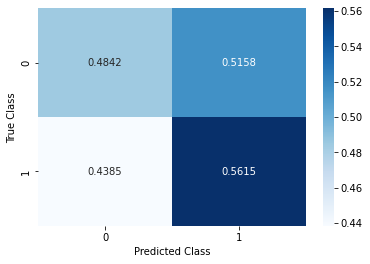

In [18]:
import seaborn as sns

cm = np.sum(best_cm[1:], axis=0)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt=".4f", cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
best_cm

[array([[   4, 1228],
        [   1, 1360]]), array([[ 268,  964],
        [ 255, 1106]]), array([[500, 732],
        [498, 863]]), array([[586, 646],
        [628, 733]]), array([[ 338,  894],
        [ 334, 1027]])]

In [ ]:
best_acc

[0.5260316236020054,
 0.5298881604319321,
 0.5256459699190127,
 0.5086772078673352,
 0.5264172772849981]

In [ ]:
best_f1

[0.6887819701190174,
 0.6447099970853978,
 0.5838971583220569,
 0.5350364963503649,
 0.6258379037172457]

In [ ]:
best_mcc

[0.028594783178342718,
 0.037547158520173346,
 0.04098843691156481,
 0.014235164507582656,
 0.03298584059016742]